In [1]:
# Now to check out how we can run a survey that uses a Markov Decision Process to generate pointings

In [2]:
from rubin_sim.scheduler.utils import Sky_area_generator, Footprint, make_rolling_footprints
from rubin_sim.scheduler.modelObservatory import Model_observatory

import healpy as hp
%matplotlib inline
import numpy as np

import rubin_sim.scheduler.basis_functions as bf
from rubin_sim.scheduler.surveys import Blob_survey
from rubin_sim.scheduler.schedulers import Core_scheduler
from rubin_sim.scheduler import sim_runner

import matplotlib.pylab as plt

## Footprints ##

First up, we want to define a large area footprint. Here's how we do it for the baseline. The end result is a dict of HEALpix maps, with filternames for keys

In [3]:
sag = Sky_area_generator()
sky_maps, labels = sag.return_maps()

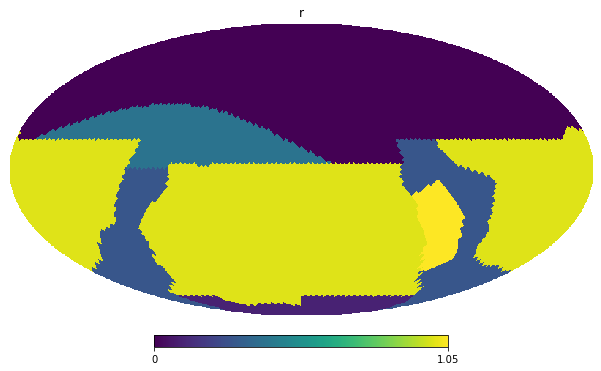

In [4]:
hp.mollview(sky_maps['r'], title='r')

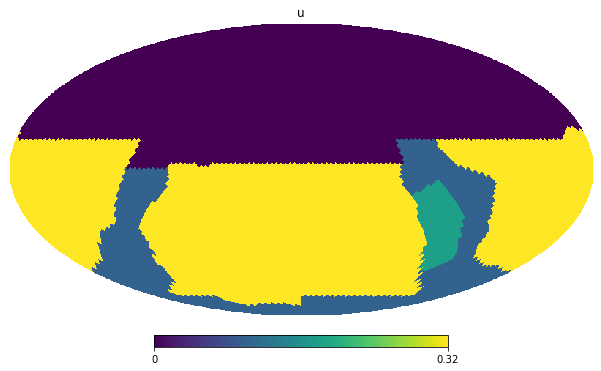

In [5]:
hp.mollview(sky_maps['u'], title='u')

0 
1 LMC_SMC
2 bulge
3 dusty_plane
4 lowdust
5 nes
6 scp
7 virgo


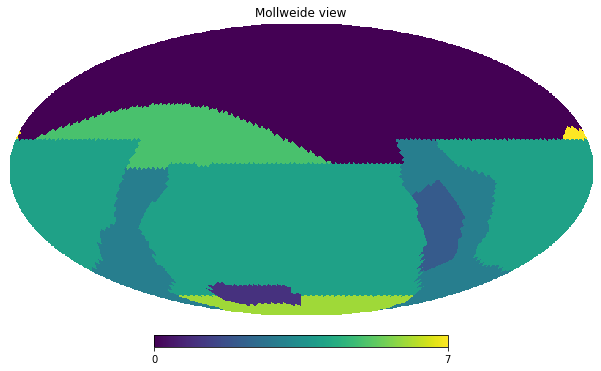

In [6]:
# Look at the labels
label_int = np.zeros(hp.nside2npix(32))
for i,label in enumerate(np.unique(labels)):
    indx = np.where(labels == label)[0]
    label_int[indx] = i
    print(i, label)
hp.mollview(label_int)


Above is what we want the footprint to look like at the end of the survey. When scheduling observations, we need to take into account that different parts of the sky have been visible for different amounts of time. To do that, we have created a footprint object

In [7]:
# How to make a footprint object

# We need the start date of the survey, so let's load up our model observatory and get that from the conditions
nside=32  # Specify the HEALpix resolution we want to do everything in.
mo = Model_observatory(nside=nside)
conditions = mo.return_conditions()



In [8]:
# Instatiate our Footprint object, and set each filter
fp = Footprint(conditions.mjd_start, conditions.sun_RA_start)
for filtername in 'ugrizy':
    fp.set_footprint(filtername, sky_maps[filtername])

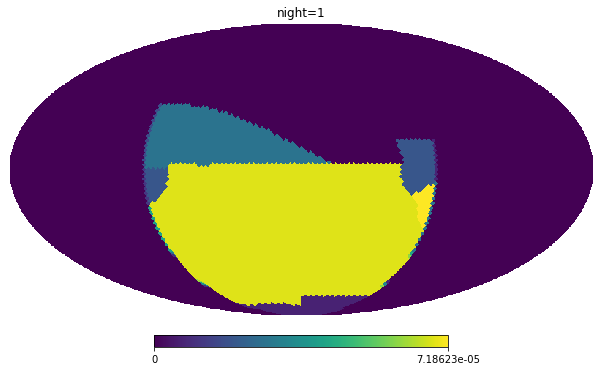

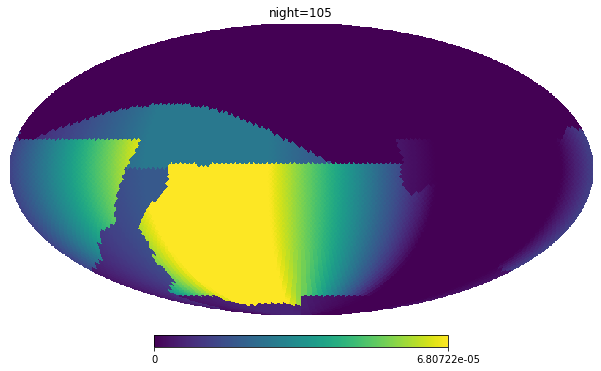

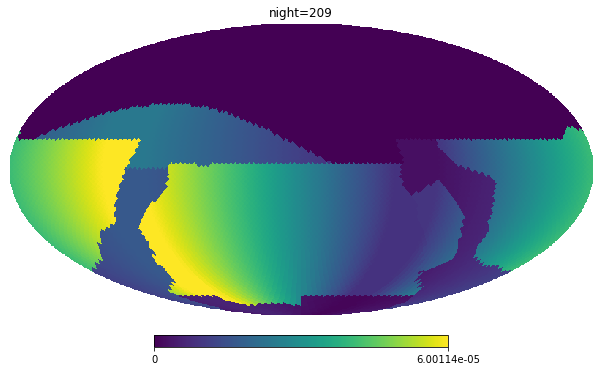

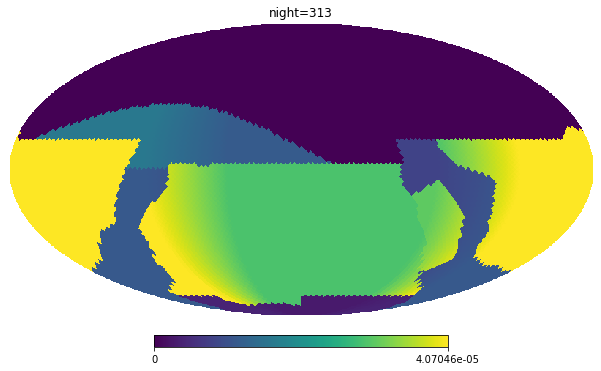

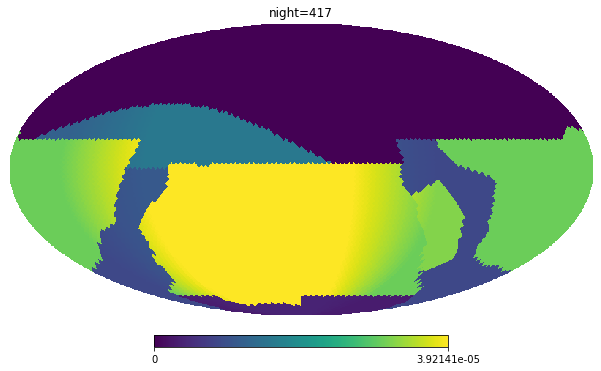

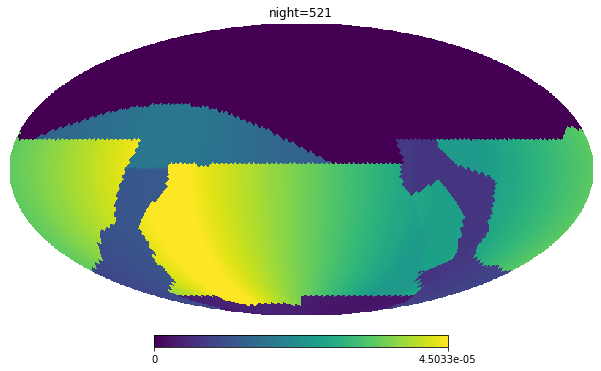

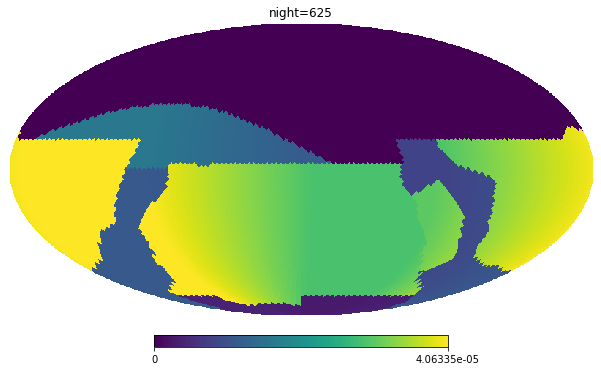

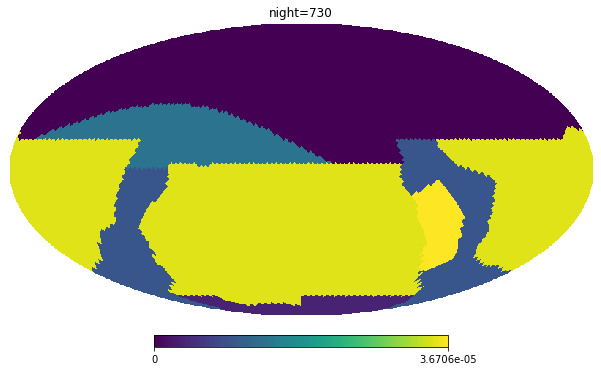

In [9]:
mjds = np.linspace(1,365*2, 8) + conditions.mjd_start

for mjd in mjds:
    fp_at_mjd = fp(mjd)
    hp.mollview(fp_at_mjd['r'], title='night=%i' % (mjd-conditions.mjd_start))

In [10]:
# The default behavior is to have a constant cadence when a HEALpix is in season. 
# A Footprint object can be confiugured to have different evolution with time. This is how we do rolling cadence

# Which HEALpix we want to roll
rolling_indx = np.where((labels == 'lowdust') | (labels == 'LMC_SMC') | (labels == 'virgo'))[0]
# How many rolling slices to make
nslice = 2 
# How strong to make the rolling
scale = 0.9
# Need a dict rather than an array
footprints_hp = {}
for key in sky_maps.dtype.names:
    footprints_hp[key] = sky_maps[key]

fp = make_rolling_footprints(fp_hp=footprints_hp, mjd_start=conditions.mjd_start,
                             sun_RA_start=conditions.sun_RA_start, nslice=nslice, scale=scale,
                             nside=nside, wfd_indx=rolling_indx)

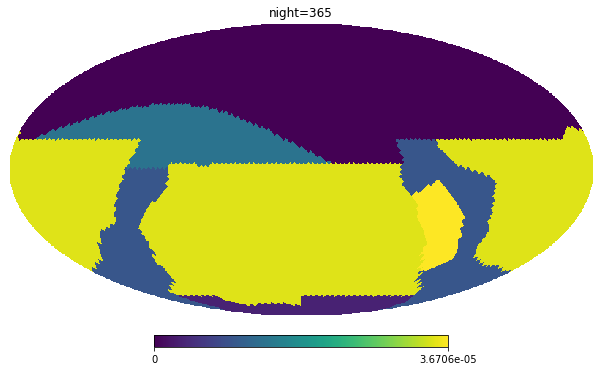

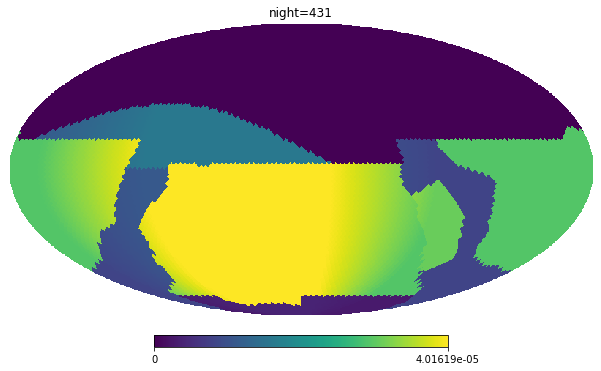

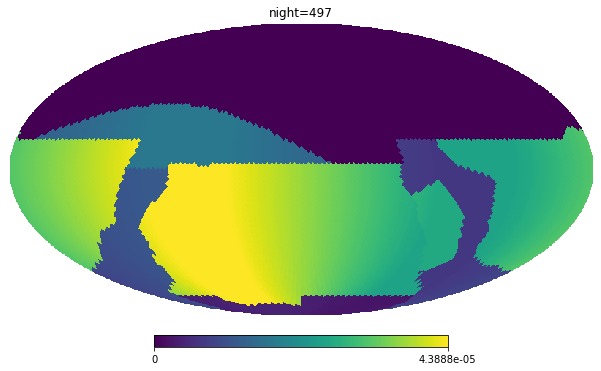

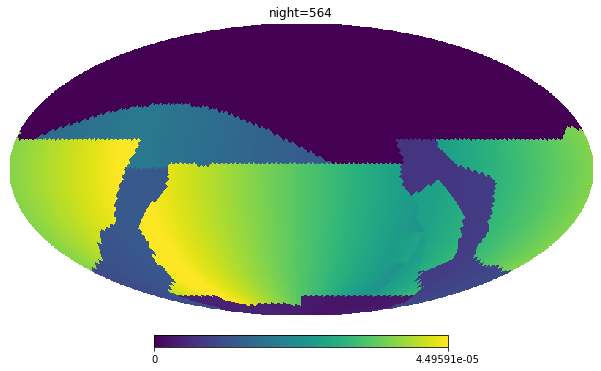

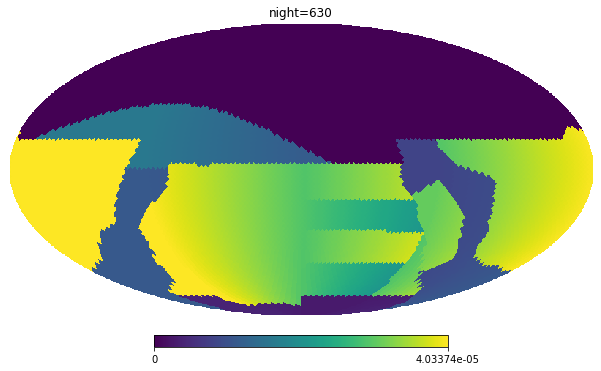

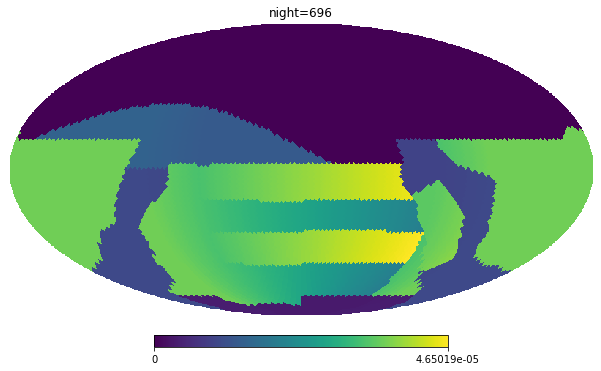

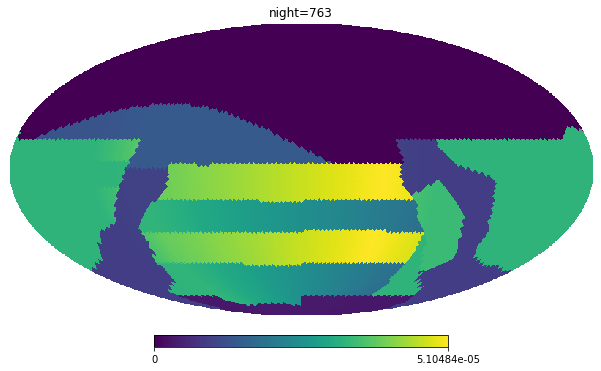

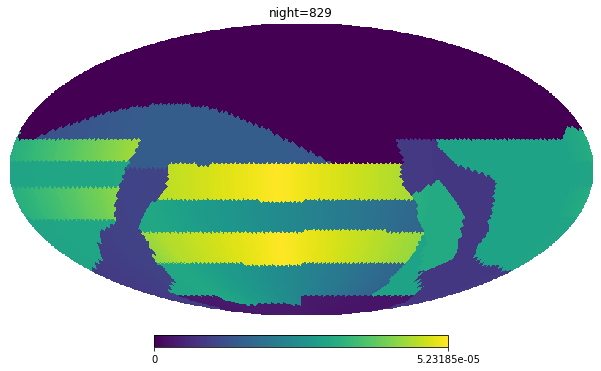

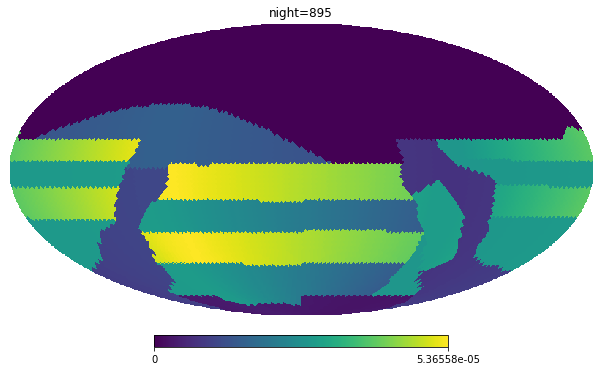

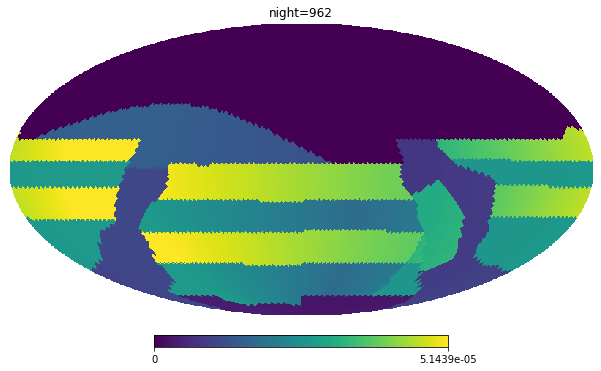

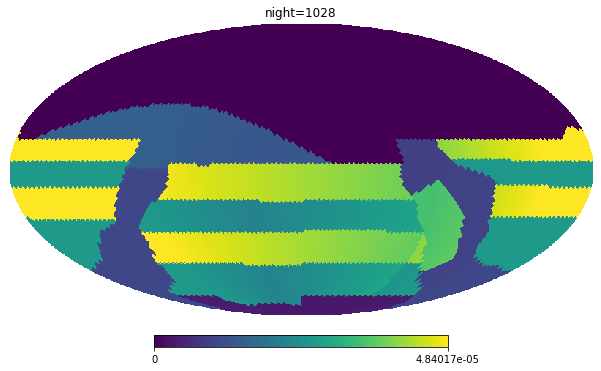

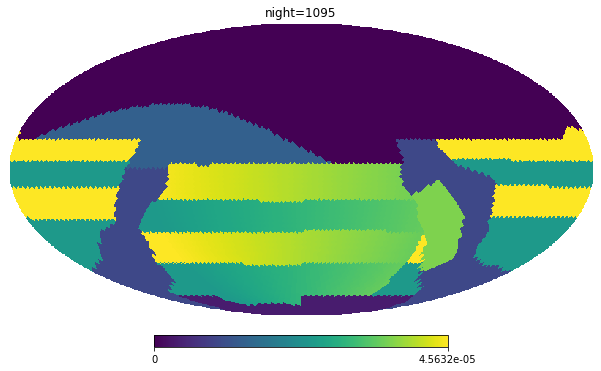

In [11]:
# skipping year 1 since there is no rolling. 
mjds = np.linspace(365,365*3, 12) + conditions.mjd_start

for mjd in mjds:
    fp_at_mjd = fp(mjd)
    hp.mollview(fp_at_mjd['r'], title='night=%i' % (mjd-conditions.mjd_start))

In [12]:
# Let's start out with a simple 2-band footprint where we want 1 observations in r for every 2 observations in g
blank_map = np.zeros(hp.nside2npix(nside))
indx = np.where((conditions.dec < 0) & (conditions.dec > np.radians(-20)))
simple_fp = {'r': blank_map + 0, 'g': blank_map + 0}
simple_fp['r'][indx] = 1
simple_fp['g'][indx] = 2

fp = Footprint(conditions.mjd_start, conditions.sun_RA_start)
for filtername in simple_fp:
    fp.set_footprint(filtername, simple_fp[filtername])

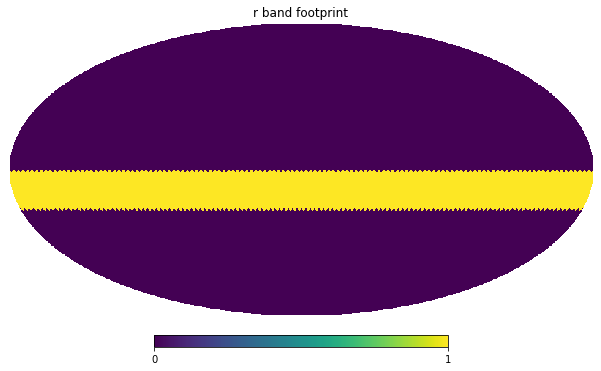

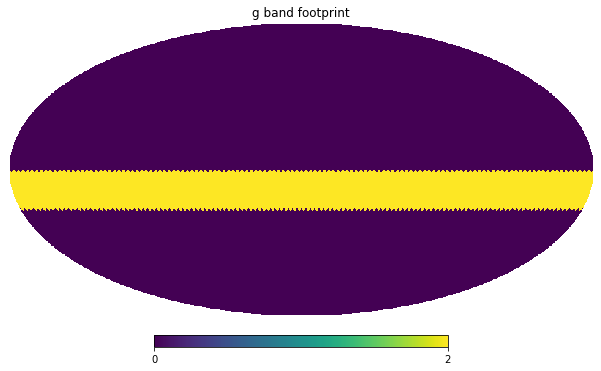

In [13]:
hp.mollview(simple_fp['r'], title='r band footprint')
hp.mollview(simple_fp['g'], title='g band footprint')


In [14]:
# Let's make two survey objects, one that will observe blobs in r, one in blue
footprint_weight = 1.

red_fp_basis = bf.Footprint_basis_function(filtername='r', footprint=fp)
red_survey = Blob_survey([red_fp_basis], [footprint_weight], filtername1='r', survey_note='r_blob')

blue_fp_basis = bf.Footprint_basis_function(filtername='g', footprint=fp)
blue_survey = Blob_survey([blue_fp_basis], [footprint_weight], filtername1='g', survey_note='g_blob')


In [15]:
scheduler = Core_scheduler([red_survey, blue_survey], nside=nside)


In [16]:
# run it for a day
try:
    mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=1.0, verbose=True)
except:
    pass

progress = 12.57%

RuntimeError: Scheduler has failed to provide a valid observation multiple times.

In [17]:
# this failed! Why, because we didn't force our survey objects to stay above the horizon. We can include the 
# M5 basis function, since it will mask any areas that are not able to be slewed to
# Let's make two survey objects, one that will observe blobs in r, one in blue
footprint_weight = 1.
m5_weight = 0

red_fp_basis = bf.Footprint_basis_function(filtername='r', footprint=fp)
m5_basis_r = bf.M5_diff_basis_function(filtername='r', nside=nside)
red_survey = Blob_survey([red_fp_basis, m5_basis_r], [footprint_weight, m5_weight], filtername1='r', survey_note='r_blob')

blue_fp_basis = bf.Footprint_basis_function(filtername='g', footprint=fp)
m5_basis_g = bf.M5_diff_basis_function(filtername='g', nside=nside)
blue_survey = Blob_survey([blue_fp_basis, m5_basis_g], [footprint_weight, m5_weight], filtername1='g', survey_note='g_blob')


scheduler = Core_scheduler([red_survey, blue_survey], nside=nside)


In [18]:
mo = Model_observatory(nside=nside)

# run it for a week
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=7.0, verbose=True)

progress = 5.41%

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:410: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


progress = 99.81%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 5224 observations
ran in 1 min = 0.0 hours
Writing results to  None


In [19]:
np.unique(observations['filter'])

array(['g', 'r'], dtype='<U1')

Text(0, 0.5, 'Altitude (degrees)')

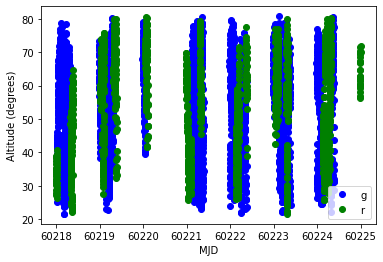

In [20]:
# let's plot and color-code by filter
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['alt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')


Text(0, 0.5, 'Moon Altitude (degrees)')

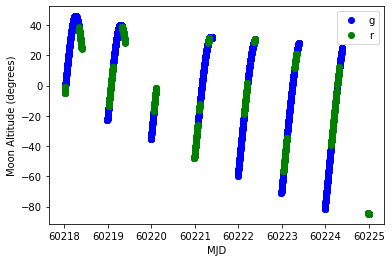

In [21]:
# let's plot and color-code by filter

for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['moonAlt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Moon Altitude (degrees)')

In [22]:
# ok, let's try this again, but now increase the weight on the m5 basis function
footprint_weight = 1.
m5_weight = 20

red_fp_basis = bf.Footprint_basis_function(filtername='r', footprint=fp)
m5_basis_r = bf.M5_diff_basis_function(filtername='r', nside=nside)
red_survey = Blob_survey([red_fp_basis, m5_basis_r], [footprint_weight, m5_weight], filtername1='r', survey_note='r_blob')

blue_fp_basis = bf.Footprint_basis_function(filtername='g', footprint=fp)
m5_basis_g = bf.M5_diff_basis_function(filtername='g', nside=nside)
blue_survey = Blob_survey([blue_fp_basis, m5_basis_g], [footprint_weight, m5_weight], filtername1='g', survey_note='g_blob')


scheduler = Core_scheduler([red_survey, blue_survey], nside=nside)


In [23]:
mo = Model_observatory(nside=nside)

# run it for a week
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=7.0, verbose=True)

progress = 5.38%

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:410: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


progress = 99.81%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 5348 observations
ran in 1 min = 0.0 hours
Writing results to  None


Text(0, 0.5, 'Altitude (degrees)')

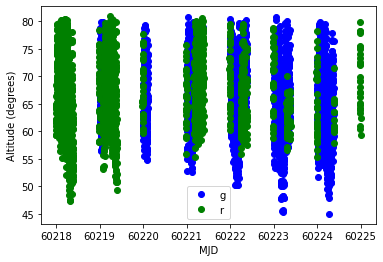

In [24]:
# let's plot and color-code by filter
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['alt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')

Text(0, 0.5, 'Moon Altitude (degrees)')

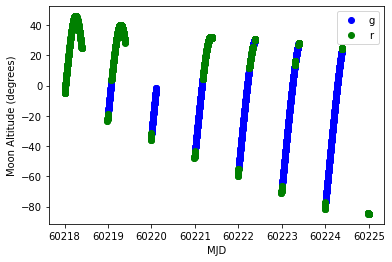

In [25]:
# let's plot and color-code by filter
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['moonAlt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Moon Altitude (degrees)')

So now we see that at the start and end of the night (twilight) and when the moon is up, the r-band survey is providing observations, then in dark time the g-band gets executed. So let's look at how the footprint basis function works

In [26]:
# We stopped mid-twilight, so let's grab the current conditions and see what the basis function looks like
conditions = mo.return_conditions()
fp_bf = scheduler.survey_lists[0][0].basis_functions[0]
fp_bf

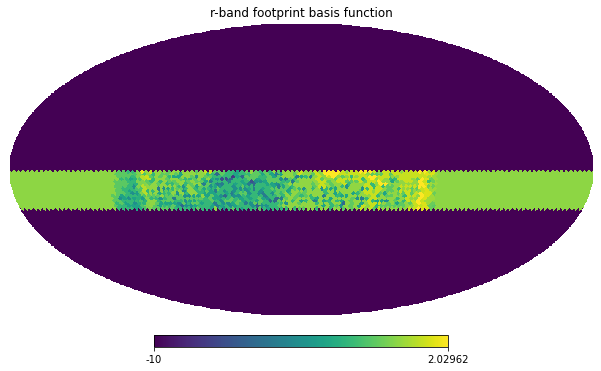

In [27]:
hp.mollview(fp_bf(conditions), title='r-band footprint basis function')

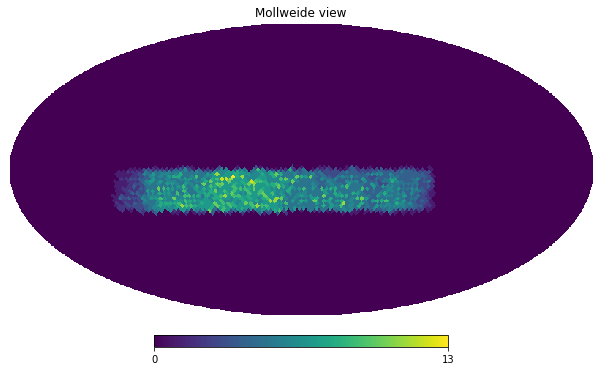

In [28]:
# The basis function holds a dict of Feature objects that track the progress of the survey
hp.mollview(fp_bf.survey_features['N_obs'](), 'title, r-band N_obs feature')

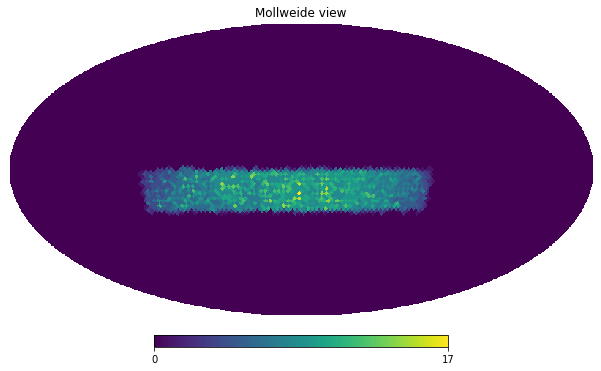

In [29]:
# And now in the g-band
hp.mollview(scheduler.survey_lists[0][1].basis_functions[0].survey_features['N_obs'](), 'title, g-band N_obs feature')

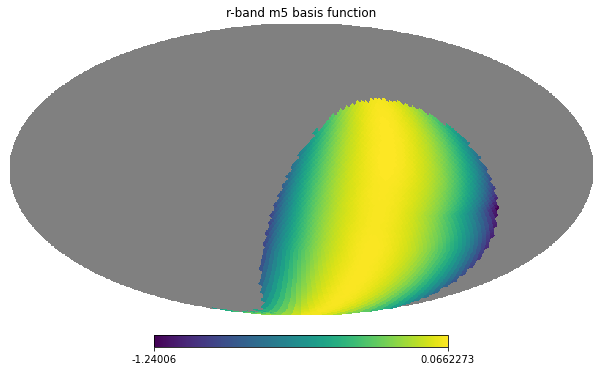

In [30]:
# Here's what the r-band m5 basis function looks like
hp.mollview(scheduler.survey_lists[0][0].basis_functions[1](conditions), title='r-band m5 basis function')

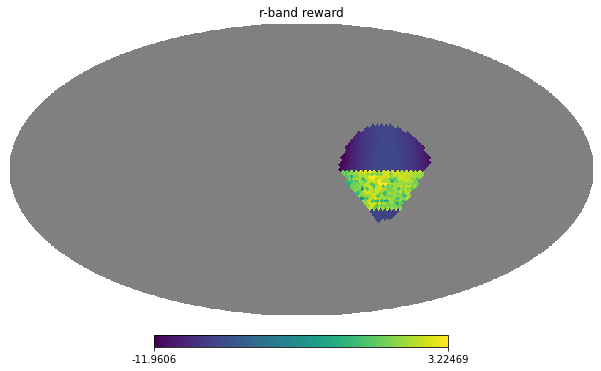

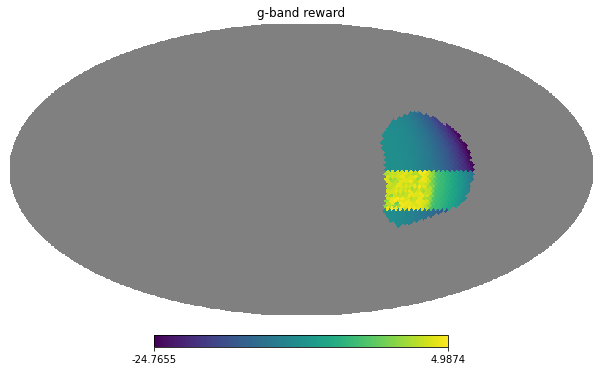

In [31]:
# The MDP survey objects have reward maps that look thusly
hp.mollview(scheduler.survey_lists[0][0].calc_reward_function(conditions), title='r-band reward')
hp.mollview(scheduler.survey_lists[0][1].calc_reward_function(conditions), title='g-band reward')


Text(0, 0.5, 'dec')

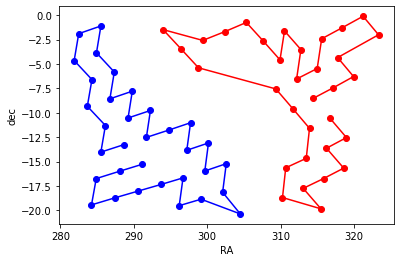

In [32]:

potential_obs_r = np.concatenate(scheduler.survey_lists[0][0].generate_observations(conditions))
potential_obs_g = np.concatenate(scheduler.survey_lists[0][1].generate_observations(conditions))
plt.plot(np.degrees(potential_obs_r['RA']), np.degrees(potential_obs_r['dec']), 'r-o')
plt.plot(np.degrees(potential_obs_g['RA']), np.degrees(potential_obs_g['dec']), 'b-o')
plt.xlabel('RA')
plt.ylabel('dec')

So, to review the relevant objects, from the ground up

## Conditions object

From the observatory model (or the observatory), the conditions object holds information about the current state of the telescope and site. 

## Feature objects

Feature objects track the progress of the survey. They have an `add_observation` method so new observations can be added. The `__call__` method returns the value of the feature. That value can be just about anything (float, int, HEALpix array, boolean, etc). 

## Basis Function objects

Basis functions have `add_observation`, `check_feasibility`, and `__call__` methods. Basis functions will often have a dict of feature objects as an attribute so that feature values can be used in the various methods.

There are some handy basis functions that make use of Footprint objects.

Basis functions can be used to regulate when a survey is able to execute (via the `check_feasibility` method), can be used to mask certain parts of the sky, and/or return a reward value. Generally a basis function the reward value should be of order unity. The returned reward must be a scalar or HEALpix array.


## Survey objects



## Detailer objects



## Core Scheduler

Takes a list (or list of list) of survey objects. The core scheduler calls the `calc_reward` method on each survey object. The one with the highest maximum gets it's `generate_observations` method called.

